# L-RVGA
## The linear regression case

In this notebook, we implement the Limited-memory Recursive Variational Approximation (L-RVGA) method of Lambert et.al for the linear regression case. We test the method on the rotation MNIST dataset.

The L-RVGA equations are given by

$$
\begin{aligned}
    q^*_t(\theta) &= \arg\min_{\mu^*, P^*}
        \text{KL}\left(  \mathcal{N}(\theta \vert \mu^*, P^*)  || \mathcal{N}(\theta \vert \mu_{t-1}, P_{t-1}^{-1}) p(y_t \vert\theta) \right)\\
    q_t(\theta) &= \arg\min_{\mu, W, \Psi}
         \text{KL}\left( \mathcal{N}(\theta \vert \left(WW^T + \Psi\right)^{-1} || \mathcal{N}(\theta \vert \mu^*, P^*)   \right)
\end{aligned}
$$

In [1]:
import jax
import chex
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from dynamax.utils import datasets
from jaxtyping import Array, Float

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(314)
key_rmnist, key_poly = jax.random.split(key)

## L-RVGA
Let $y_t = \theta^T x_t + \epsilon_t$, $\epsilon_t \sim \mathcal{N}(0, 1)$. Considering the approximated R-VGA, the update for $\mu_t\in\mathbb{R}^{d}$, $W_t\in\mathbb{R}^{d\times p}$, and $\Psi_t\in\mathbb{R}^{d\times d}$ in L-RVGA becomes

$$
\begin{aligned}
\mu_t &= \mu_{t-1} + \left(W_t W_t^\intercal + \Psi_t\right)^{-1}x_t\left(y_t - \mu_{t-1}^\intercal x_t\right)\\
W_t W_t^\intercal + \Psi_t &\underset{\text{FA}}{\approx} \alpha_t\left( W_{t-1}W_{t-1}^\intercal + \Psi_{t-1} \right) + \beta x_tx_t^\intercal
\end{aligned}
$$

The FA update for the posterior covariance is obtained by iterating `nb_inner_loop` number of times the following set of equations

$$
\begin{aligned}
M &= {\bf I}_p + W^\intercal \Psi^{-1} W\\
V &= \beta_t x_tx_t^\intercal\Psi^{-1} W + \alpha_t\left[ W_{t-1}W_{t-1}^\intercal \Psi^{-1} W + \Psi_{t-1}\Psi^{-1} W \right]\\
W^{(n)} &= V\left({\bf I}_p + M^{-1} W^\intercal\Psi^{-1}V\right)^{-1}\\
\Psi^{(n)} &= \beta_t \text{diag}\left(x_tx_t^\intercal\right) + \alpha_t \text{diag}\left(W_{t-1}W_{t-1}^\intercal\right) + \alpha_t\Psi_{t-1} - \text{diag}\left(W^{(n)}M^{-1}V^\intercal\right)\\
W &= W^{(n)}, \Psi = \Psi^{(n)}
\end{aligned}
$$

To efficiently estimate $W^{(n)}$, we note that its solution given by a broadcasted version of the linear system $xA = b$. To make use of linear solvers, we rewrite this equation as $A^\intercal x^\intercal = b^\intercal$. Hence, setting $A^\intercal = \left({\bf I}_p + M^{-1} W^\intercal\Psi^{-1}V\right)^\intercal$, $b^\intercal = V^\intercal$ estimates $W^{(n)\intercal}$ using a linear solver.

In [4]:
@chex.dataclass
class LRVGAState:
    mu: Float[Array, "dim_params"]
    W: Float[Array, "dim_params dim_subspace"]
    Psi: Float[Array, "dim_params"]


def fa_approx_step(
    x: Float[Array, "num_obs"],
    state: LRVGAState,
    state_prev: LRVGAState,
    alpha: float,
    beta: float
) -> LRVGAState:
    """
    Factor Analysis (FA) approximation to the low-rank (W)
    and diagonal (Psi) matrices.
    """
    # Load data
    W_prev, Psi_prev = state_prev.W, state_prev.Psi
    W, Psi = state.W, state.Psi
    
    # Initialise basic transformations
    dim_obs, dim_latent = W.shape
    I = jnp.eye(dim_latent)
    Psi_inv = 1 / Psi
    
    # Construct helper matrices
    M = I + jnp.einsum("ij,i,ik->jk", W, Psi_inv, W)
    M_inv = jnp.linalg.inv(M)
    V_beta = jnp.einsum("i,j,j,jk->ik", x, x, Psi_inv, W)
    V_alpha = (
        jnp.einsum("ij,kj,k,kl->il", W_prev, W_prev, Psi_inv, W) +
        jnp.einsum("i,i,ij->ij", Psi_prev, Psi_inv, W)
    )
    V = beta * V_beta + alpha * V_alpha
    # Value_update
    # (return transpose of W_solve -- avoid extra transpose op)
    W_solve = I + jnp.einsum("ij,kj,k,kl->li", M_inv, W, Psi_inv, V)
    W = jnp.linalg.solve(W_solve, V.T).T
    # TODO: Solve the `+ dim_obs` bug
    Psi = (
        beta * jnp.einsum("i,i->i", x, x) + dim_obs +
        alpha * jnp.einsum("ij,ij->i", W_prev, W_prev) + 
        alpha * Psi_prev -
        jnp.einsum("ij,jk,ik->i", W, M_inv, V)
    )
    
    new_state = state.replace(
        mu=state.mu,
        W=W,
        Psi=Psi
    )
    return new_state

### Initialisiation

We consider the initialisiation rule of §5.1.2:
1. $\Psi_0 = \psi_0 {\bf I}_d$, where $\psi_0 > 0$,
2. $W_0 \in \mathbb{R}^{d\times p}$,  where the columns are random vectors independently drawn from an istropic Gaussian distribution in $\mathbb{R}^d$ and which have been normalised so that $\forall k. ||u_k|| = w_0$.
We let

$$
\begin{aligned}
    \psi_0 &= (1 - \epsilon) \frac{1}{\sigma^2_0},\\
    w_0 &= \sqrt{\frac{\epsilon d}{p\sigma^2_0}}
\end{aligned}
$$

with $0 < \epsilon \ll 1$ a small parameter.

In [5]:
def init_state_lrvga(key, X, dim_latent, sigma2_init, eps):
    key_W, key_mu = jax.random.split(key)
    _, dim_obs = X.shape
    psi0 = (1 - eps) / sigma2_init
    w0 = jnp.sqrt((eps * dim_obs) / (dim_latent * sigma2_init))
    
    W_init = jax.random.normal(key_W, (dim_obs, dim_latent))
    W_init = W_init / jnp.linalg.norm(W_init, axis=0) * w0
    Psi_init = jnp.ones(dim_obs) * psi0
    
    mu_init = jax.random.normal(key_mu, (dim_obs,))
    mu_init = jnp.zeros((dim_obs,))
    
    state_init = LRVGAState(
        mu=mu_init,
        W=W_init,
        Psi=Psi_init
    )
    
    return state_init

> The update in $\mu_t$ [for a linear regression problem] can be rewritten in a limited fashion involving only operations linear in d:

$$
    \mu_t
    = \mu_{t-1} + \Psi_t^{-1}\left( x_t - W_t\left({\bf I}_p + W_t^\intercal\Psi_t^{-1}W_t\right)^{-1} \left(W_t^\intercal\Psi_t^{-1}x_t\right)\right)(y_t - \mu_{t-1}^Tx_t)
$$

In [6]:
@jax.jit
def mu_update(
    state: LRVGAState,
    x: Float[Array, "dim_obs"],
    y: float
) -> Float[Array, "dim_obs"]:
    mu = state.mu
    W = state.W
    Psi_inv = 1 / state.Psi
    dim_obs, dim_latent = W.shape
    I = jnp.eye(dim_latent)
    
    err = y - jnp.einsum("i,i->", mu, x)

    # TODO: double check
    M = I + jnp.einsum("ij,i,ik->jk", W, Psi_inv, W)
    b_matrix = jnp.einsum("ij,i,i->j", W, Psi_inv, x)
    term_1 = jnp.linalg.solve(M, b_matrix)
    term_2 = jnp.einsum("ij,j->i", W, term_1)
    
    mu = mu + Psi_inv * (x - term_2) * err
    return mu

In the linear regression setting, updates on $\mu_t$ do no affect the estimation of $W_t$ and $\Psi_t$. Hence, we iterate multiple times the EM equations and only once for the $\mu_t$ update.

## L-RVGA iteration

In [7]:
def _step_lrvga(state, obs, alpha, beta):
    x, y = obs

    def fa_partial(_, new_state):
        new_state = fa_approx_step(x, new_state, state, alpha, beta)
        return new_state

    # Algorithm 1 in §3.2 of L-RVGA states that 1 to 3 loops may be enough in
    # the inner (fa-update) loop
    state_update = jax.lax.fori_loop(0, 3, fa_partial, state)
    mu_new = mu_update(state_update, x, y)
    state_update = state_update.replace(mu=mu_new)
    
    return state_update, mu_new


def lrvga(
    state_init: LRVGAState,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    alpha: float,
    beta: float,
):
    part_lrvga = partial(_step_lrvga, alpha=alpha, beta=beta)
    obs = (X, y)
    state_final, mu_hist = jax.lax.scan(part_lrvga, state_init, obs)
    return state_final, mu_hist

## Rotation MNIST

In [8]:
%%time
np.random.seed(314)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2, n_processes=1)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_train = jnp.array(X_train)[:num_train]
y_train = jnp.array(y_train)[:num_train]

num_test = len(y_test)
# ix_sort = jnp.argsort(y)
# X = X[ix_sort]
# y = y[ix_sort]

CPU times: user 2.87 s, sys: 34.1 ms, total: 2.9 s
Wall time: 1.21 s


In [9]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Add bias term
X_train = jnp.c_[X_train, jnp.ones(num_train)]
X_test = jnp.c_[X_test, jnp.ones(num_test)]

### Evaluate L-RVGA

In [10]:
%%time
dim_subspace = 5
sigma2_init = 1.0
alpha, beta = 0.5, 1.0
state_init = init_state_lrvga(key_rmnist, X_train, dim_subspace, sigma2_init, eps=1e-6)

state_final, mu_hist = lrvga(state_init, X_train, y_train, alpha, beta)

yhat = jnp.einsum("nm,m->n", X_test, state_final.mu)
# Residual mean absolute error
rmae = jnp.abs(y_test - yhat).mean().item()
print(f"test R-MAE: {rmae:0.4f}")

test R-MAE: 24.0962
CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 980 ms


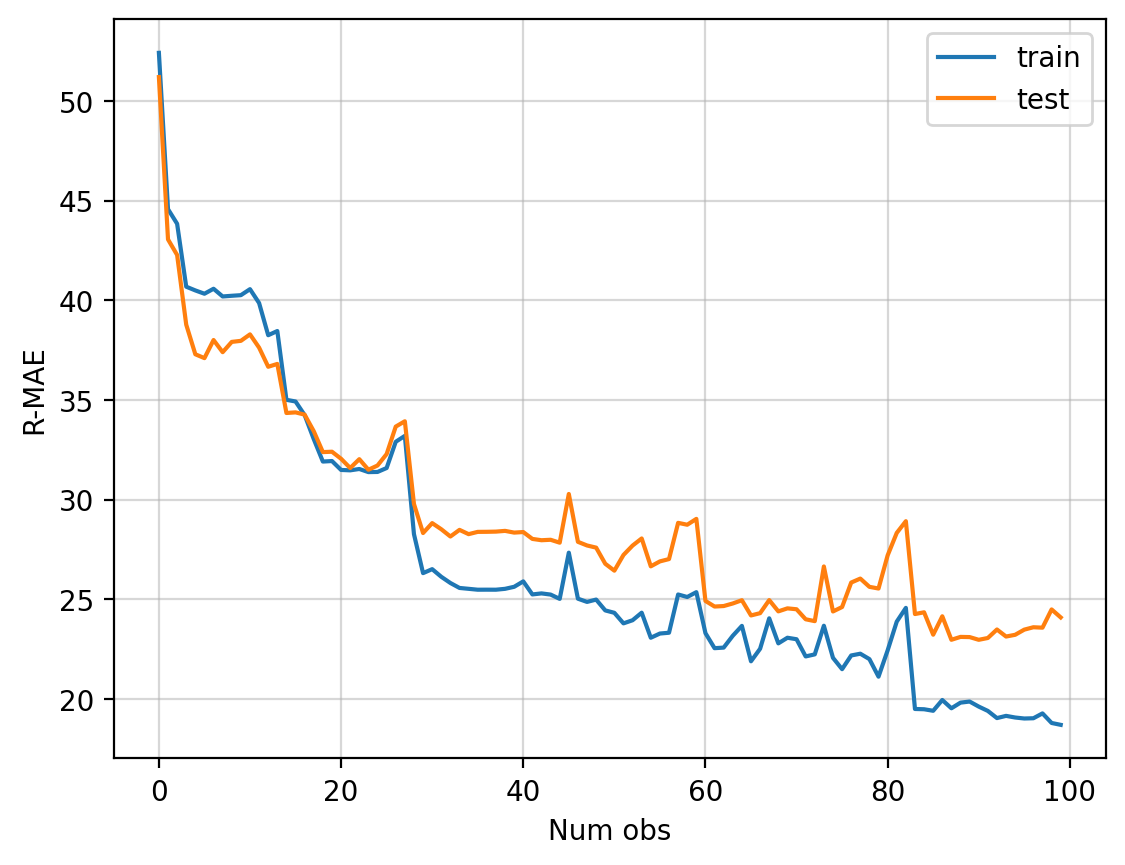

In [11]:
yhat_hist_test = jnp.einsum("nm,tm->tn", X_test, mu_hist)
yhat_hist_train = jnp.einsum("nm,tm->tn", X_train, mu_hist)

err_hist_test = jnp.abs(yhat_hist_test - y_test[None, :]).mean(axis=-1)
err_hist_train = jnp.abs(yhat_hist_train - y_train[None, :]).mean(axis=-1)

plt.plot(err_hist_train, label="train")
plt.plot(err_hist_test, label="test")
plt.legend()
plt.xlabel("Num obs")
plt.ylabel("R-MAE")
plt.grid(alpha=0.5)

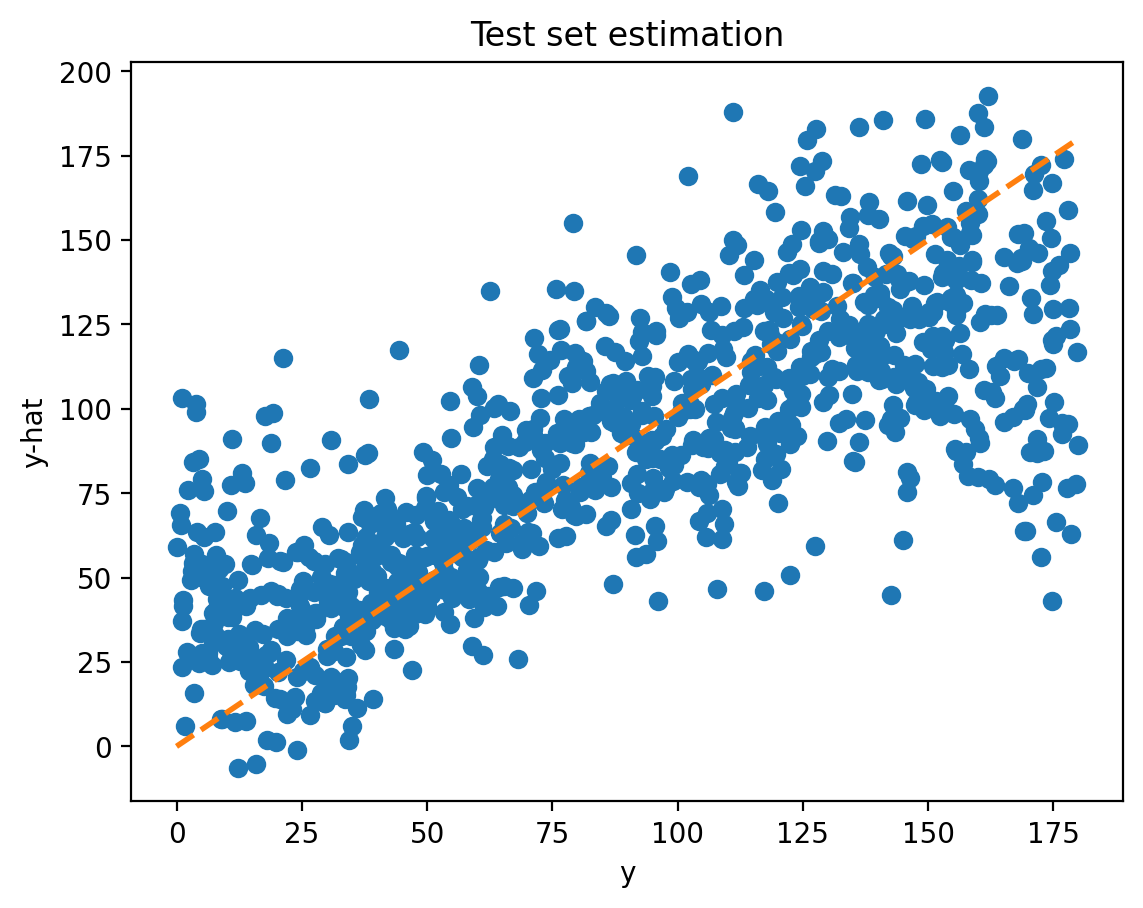

In [12]:
plt.scatter(y_test, yhat)
plt.xlabel("y")
plt.ylabel("y-hat")
plt.plot([0,180], [0, 180], c="tab:orange", linestyle="--", linewidth=2)
plt.title("Test set estimation");

## Polynomial dataset

### Load data

In [13]:
n_train = 300
n_test = 150
n_total = n_train + n_test

key_x, key_y = jax.random.split(key_poly)
xvals = jax.random.uniform(key_x, (n_total, 1), minval=-4, maxval=3)
X = jnp.c_[xvals, xvals ** 2, xvals ** 3]

theta = jnp.array([2.0, -1.0, -0.5])
eps_vals = jax.random.normal(key_y, (n_total,))
y = jnp.einsum("m,nm->n", theta, X) + eps_vals


X_test = X[-n_test:]
y_test = y[-n_test:]

X_train = X[:-n_test]
y_train = y[:-n_test]

xvals_test = xvals[-n_test:].ravel()
xvals_train = xvals[:-n_test]


num_train = len(y_train)
num_test = len(y_test)
X_train = jnp.c_[X_train, jnp.ones(num_train)]
X_test = jnp.c_[X_test, jnp.ones(num_test)]

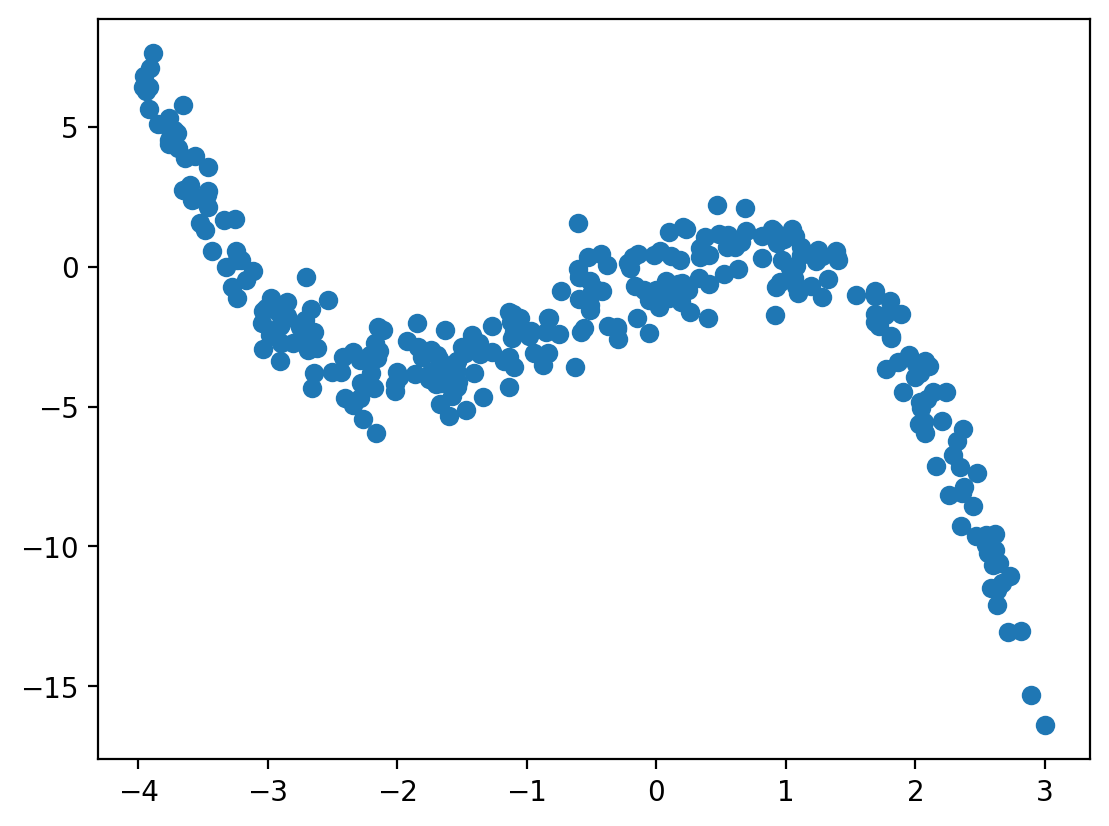

In [14]:
plt.scatter(xvals_train, y_train)

### Evaluate L-RVGA

In [15]:
%%time
alpha, beta = 0.9, 1.0
state_init = init_state_lrvga(key, X_train, dim_subspace, sigma2_init, eps=1e-6)
state_final, mu_hist = lrvga(state_init, X_train, y_train, alpha, beta)

yhat = jnp.einsum("nm,m->n", X_test, state_final.mu)
# Residual mean absolute error
rmae = jnp.abs(y_test - yhat).mean().item()
print(f"test R-MAE: {rmae:0.4f}")

test R-MAE: 0.8793
CPU times: user 1.11 s, sys: 26.7 ms, total: 1.14 s
Wall time: 866 ms


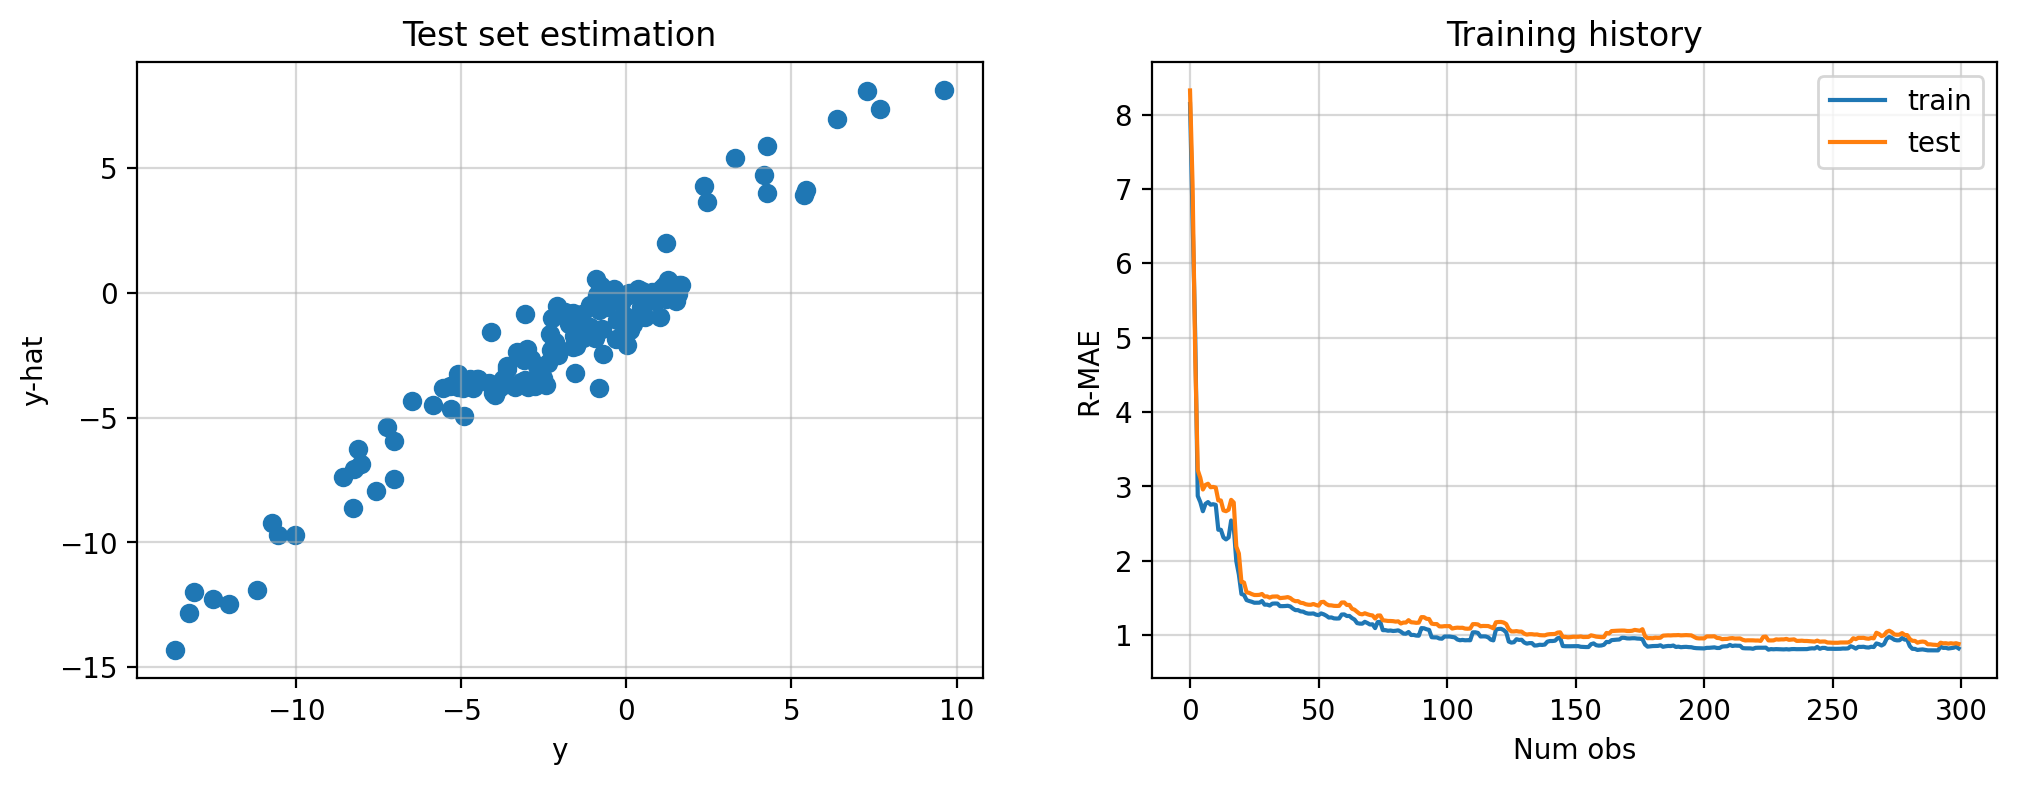

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

yhat_hist_test = jnp.einsum("nm,tm->tn", X_test, mu_hist)
yhat_hist_train = jnp.einsum("nm,tm->tn", X_train, mu_hist)

err_hist_test = jnp.abs(yhat_hist_test - y_test[None, :]).mean(axis=-1)
err_hist_train = jnp.abs(yhat_hist_train - y_train[None, :]).mean(axis=-1)

ax[0].scatter(y_test, yhat)
ax[0].set_xlabel("y")
ax[0].set_ylabel("y-hat")
ax[0].set_title("Test set estimation")
ax[0].grid(alpha=0.5)

ax[1].plot(err_hist_train, label="train")
ax[1].plot(err_hist_test, label="test")
ax[1].legend()
ax[1].set_xlabel("Num obs")
ax[1].set_ylabel("R-MAE")
ax[1].set_title("Training history")
ax[1].grid(alpha=0.5)